In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
books_df = pd.read_csv("C:/Users/user/OneDrive - University of Hertfordshire/dissertaion/disserataion_dataset/Books.csv", low_memory=False)
users_df = pd.read_csv('C:/Users/user/OneDrive - University of Hertfordshire/dissertaion/disserataion_dataset/users.csv', low_memory=False)
ratings_df = pd.read_csv('C:/Users/user/OneDrive - University of Hertfordshire/dissertaion/disserataion_dataset/Ratings.csv', low_memory=False)

In [19]:
# Data cleaning and preprocessing
books_df = books_df.dropna()
users_df = users_df.dropna()
ratings_df = ratings_df.dropna()


users_df = users_df[(users_df['Age'] > 10) | (users_df['Age'].isnull())]


In [20]:
merged_df = pd.merge(books_df, ratings_df, on='ISBN').drop_duplicates()
merged_df = merged_df.loc[:, ~merged_df.columns.str.contains('#NAME?')]
merged_df = merged_df.fillna(0)
merged_df


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0
...,...,...,...,...,...,...,...,...,...,...
1031124,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,276463,7
1031125,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,276579,4
1031126,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,276680,0
1031127,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,276680,0


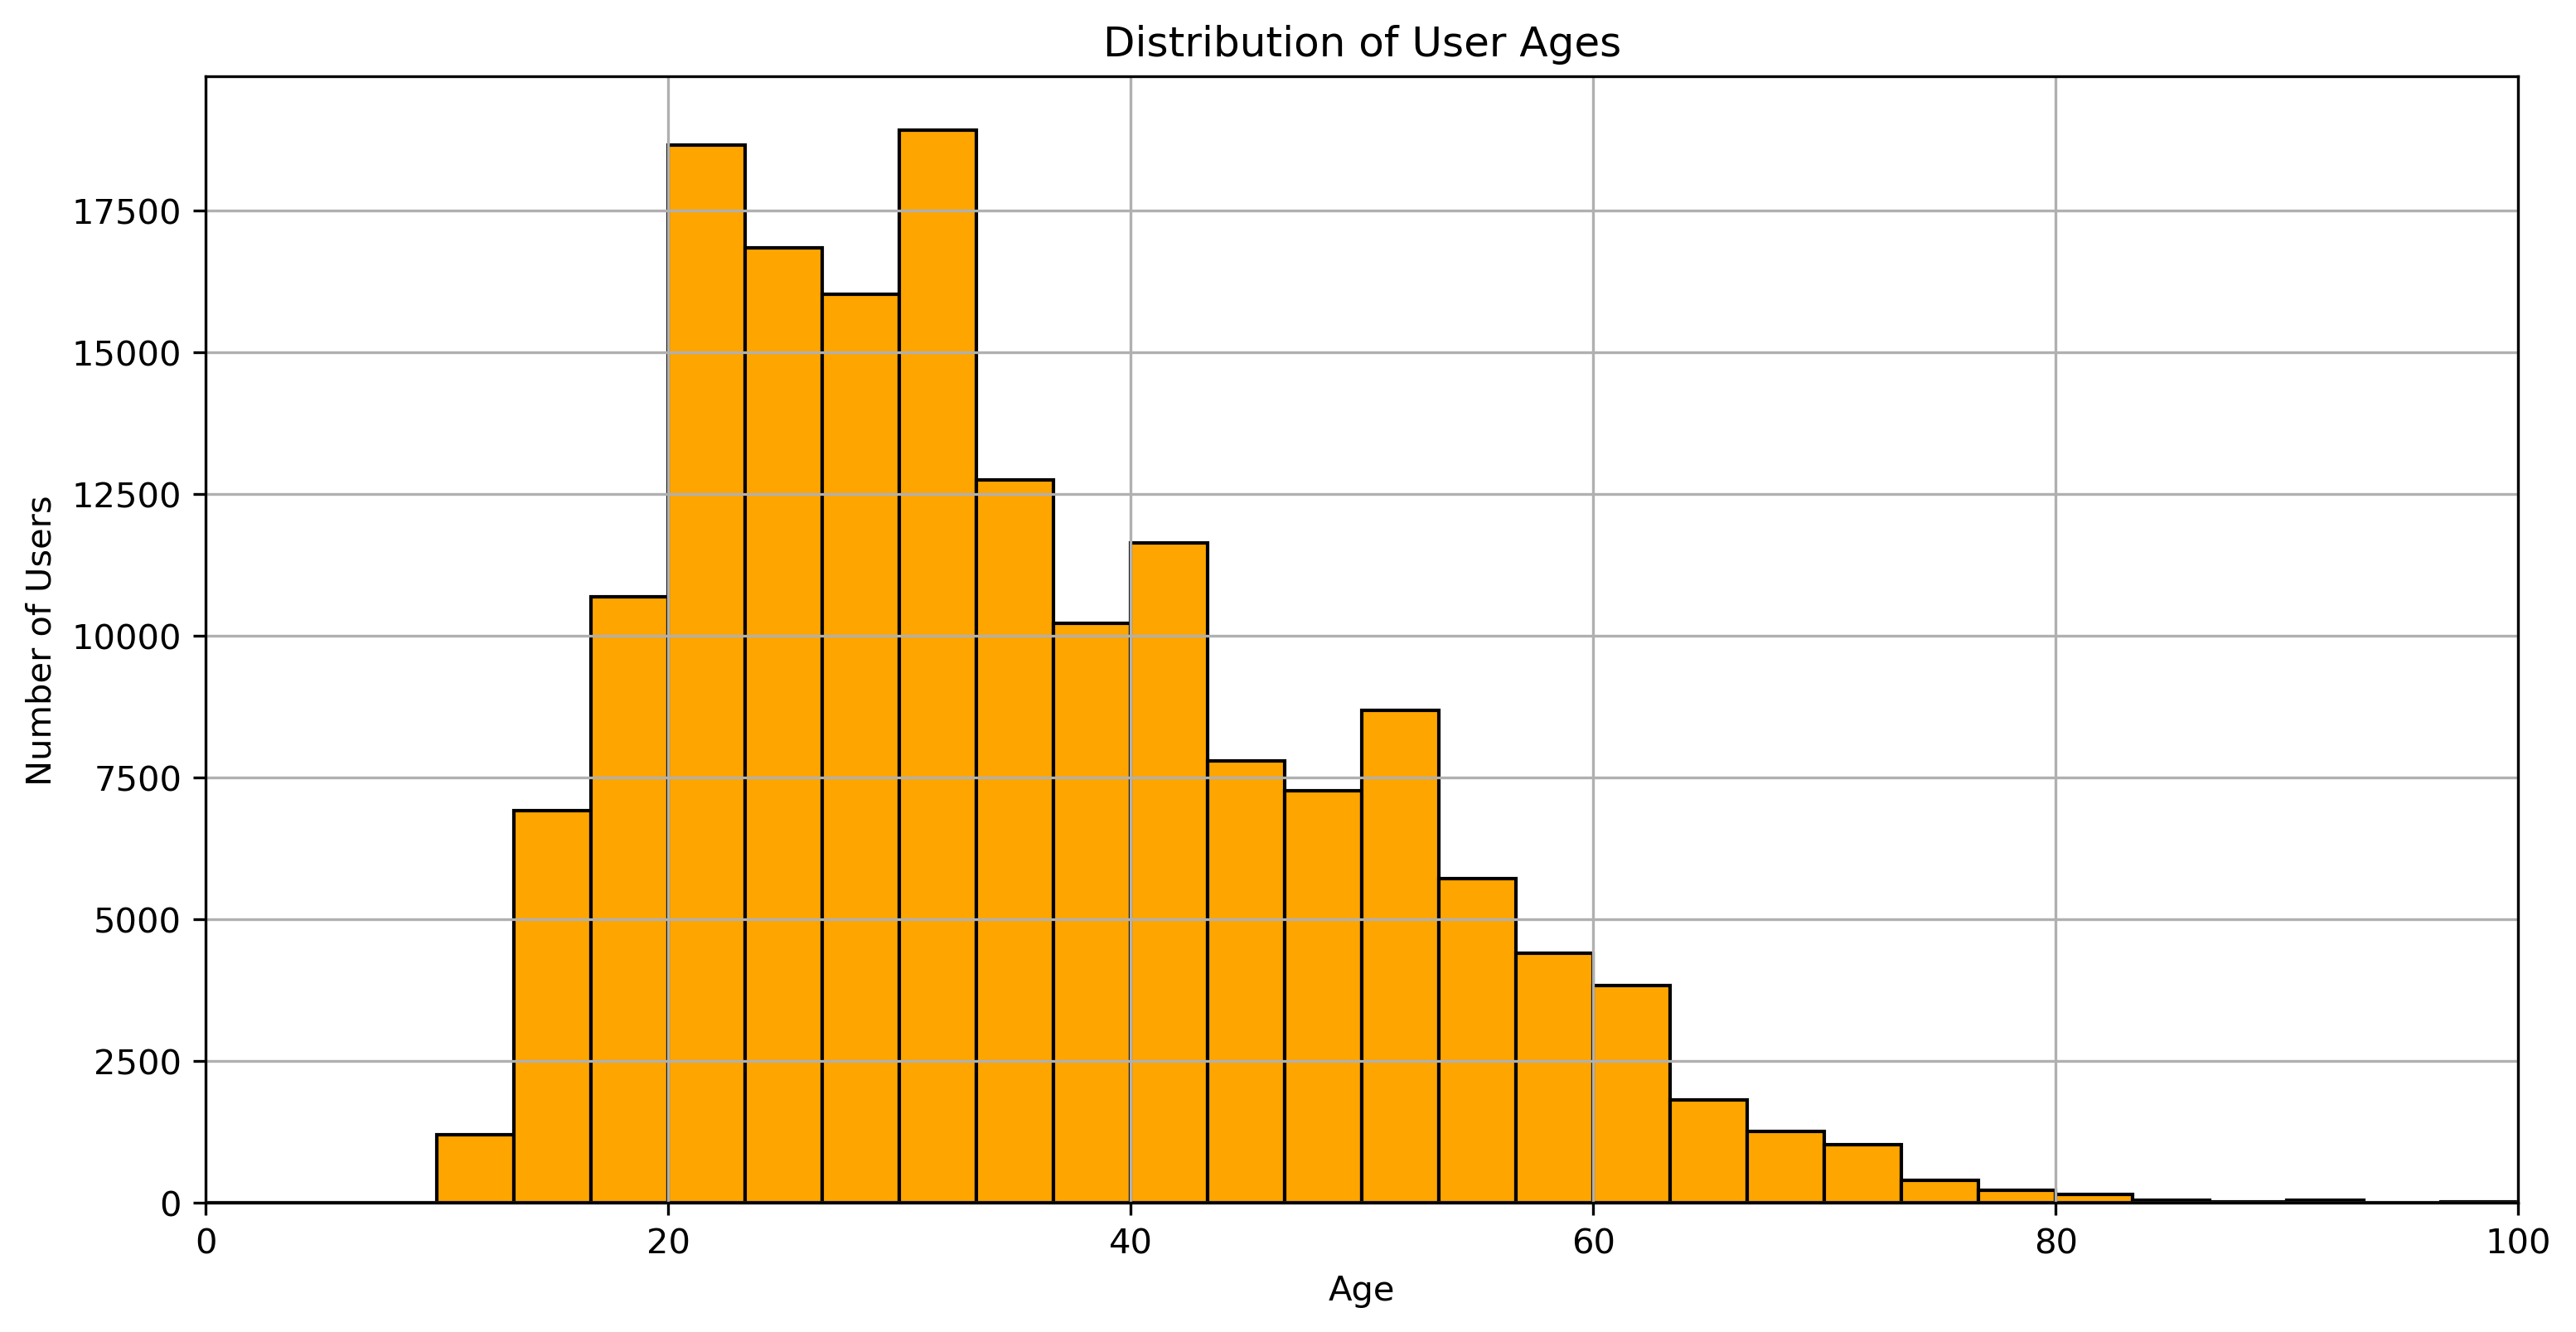

In [21]:

# Assuming users_df is already loaded
plt.figure(figsize=(12, 6), dpi=300)
plt.hist(users_df['Age'].dropna(), bins=30, color='orange', edgecolor='black', range=(0, 100))
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.grid(True)
plt.xlim(0, 100)
plt.show()


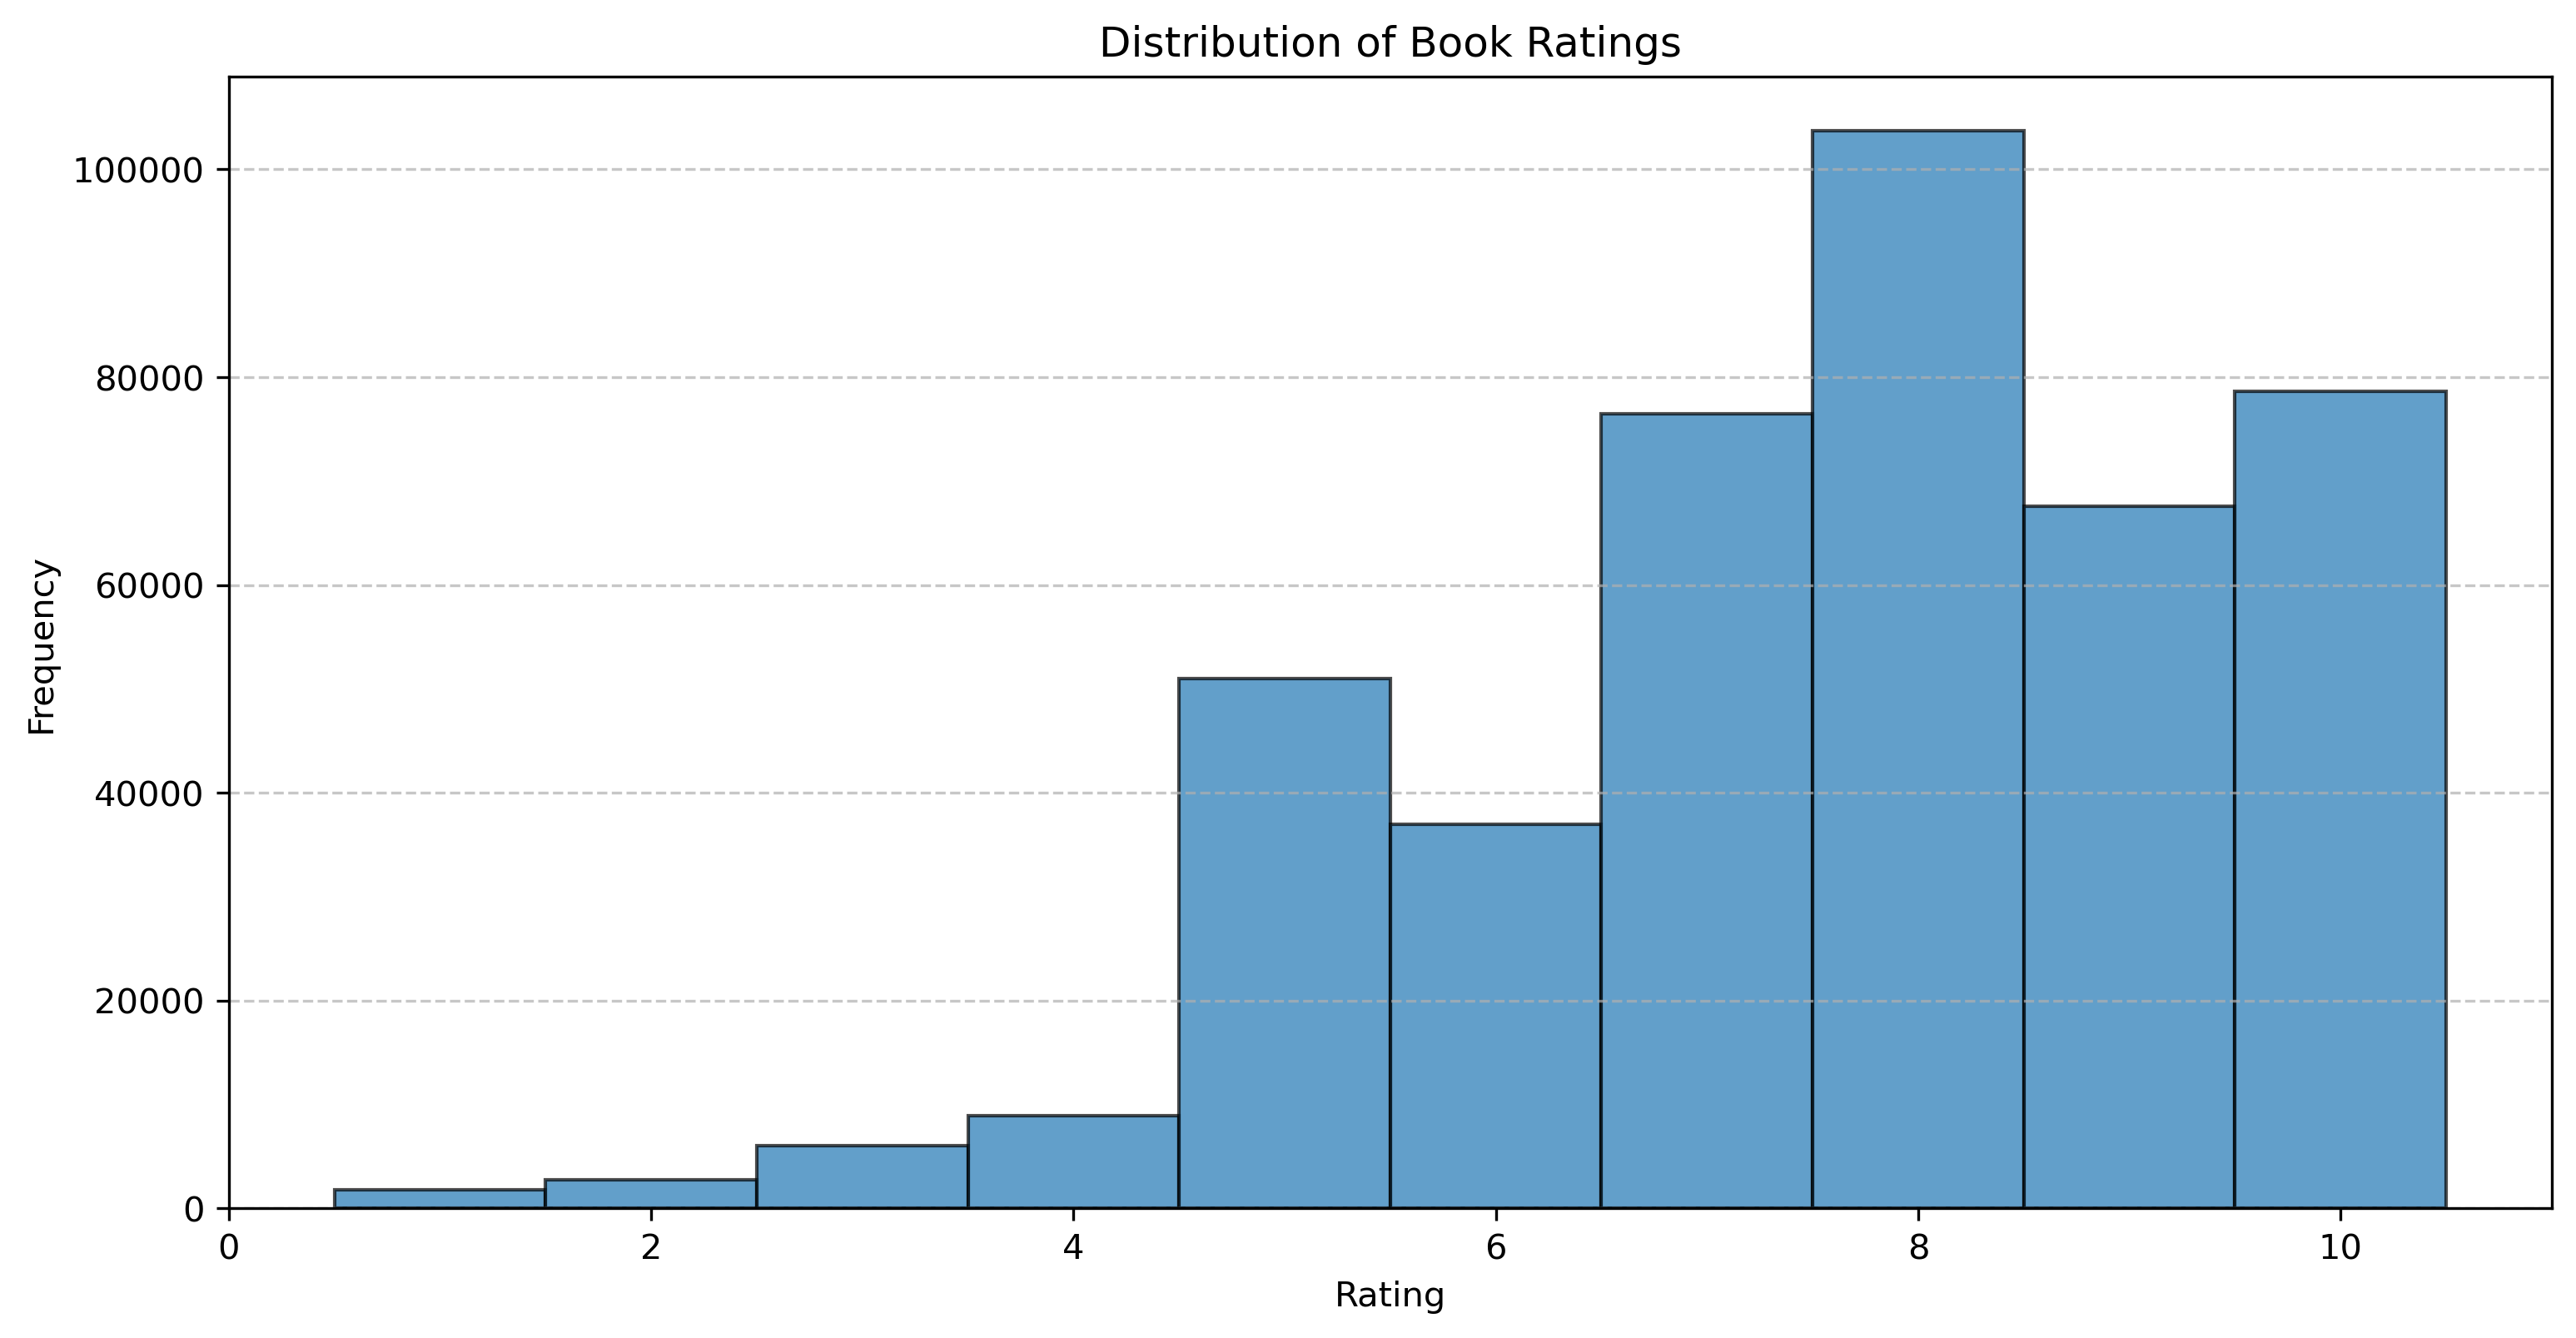

In [22]:
# 1. Histogram of Book Ratings
plt.figure(figsize=(12, 6),dpi=300)
plt.hist(ratings_df['Book-Rating'], bins=np.arange(0.5, 11.5, 1), edgecolor='black', alpha=0.7)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
# Calculating book popularity
Rating_count = merged_df.groupby('Book-Title').count()['Book-Rating'].reset_index()
Rating_count.rename(columns={'Book-Rating': 'Rating Count'}, inplace=True)


In [24]:
AvgRating_count = merged_df.groupby('Book-Title').mean()['Book-Rating'].reset_index()
AvgRating_count.rename(columns={'Book-Rating': 'Avg Rating'}, inplace=True)


In [25]:
#popular_df = Rating_count.merge(AvgRating_count, on='Book-Title')
#popular_df = popular_df[popular_df['Rating Count'] >= 100]
#popular_df = popular_df.sort_values('Avg Rating', ascending=False).head(50)

In [26]:
x = merged_df.groupby('User-ID').count()['Book-Rating'] > 200
exp_users = x[x].index

In [27]:
filtered_rating_users = merged_df[merged_df['User-ID'].isin(exp_users)]
y = filtered_rating_users.groupby('Book-Title').count()['Book-Rating'] > 50
famous_books = y[y].index


In [28]:
final_ratings = filtered_rating_users[filtered_rating_users['Book-Title'].isin(famous_books)]
final_ratings['merged_words'] = final_ratings['Book-Title'] + ' ' + final_ratings['Book-Author'] + ' ' + final_ratings['Publisher']
final_ratings

C:\Users\user\AppData\Local\Temp\ipykernel_9472\3222437547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_ratings['merged_words'] = final_ratings['Book-Title'] + ' ' + final_ratings['Book-Author'] + ' ' + final_ratings['Publisher']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,merged_words
31,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,11676,9,The Kitchen God's Wife Amy Tan Putnam Pub Group
33,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,36836,0,The Kitchen God's Wife Amy Tan Putnam Pub Group
34,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,46398,9,The Kitchen God's Wife Amy Tan Putnam Pub Group
38,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,113270,0,The Kitchen God's Wife Amy Tan Putnam Pub Group
39,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,113519,0,The Kitchen God's Wife Amy Tan Putnam Pub Group
...,...,...,...,...,...,...,...,...,...,...,...
1028407,1878702831,Echoes,Nancy Morse,1992,Meteor Publishing Corporation,http://images.amazon.com/images/P/1878702831.0...,http://images.amazon.com/images/P/1878702831.0...,http://images.amazon.com/images/P/1878702831.0...,238781,0,Echoes Nancy Morse Meteor Publishing Corporation
1028593,0394429869,I Know Why the Caged Bird Sings,Maya Angelou,1996,Random House,http://images.amazon.com/images/P/0394429869.0...,http://images.amazon.com/images/P/0394429869.0...,http://images.amazon.com/images/P/0394429869.0...,239594,8,I Know Why the Caged Bird Sings Maya Angelou R...
1028595,0449001164,The Promise,CHAIM POTOK,1997,Ballantine Books,http://images.amazon.com/images/P/0449001164.0...,http://images.amazon.com/images/P/0449001164.0...,http://images.amazon.com/images/P/0449001164.0...,239594,7,The Promise CHAIM POTOK Ballantine Books
1028808,0743527631,The Pillars of the Earth,Ken Follett,2002,Encore,http://images.amazon.com/images/P/0743527631.0...,http://images.amazon.com/images/P/0743527631.0...,http://images.amazon.com/images/P/0743527631.0...,240144,0,The Pillars of the Earth Ken Follett Encore


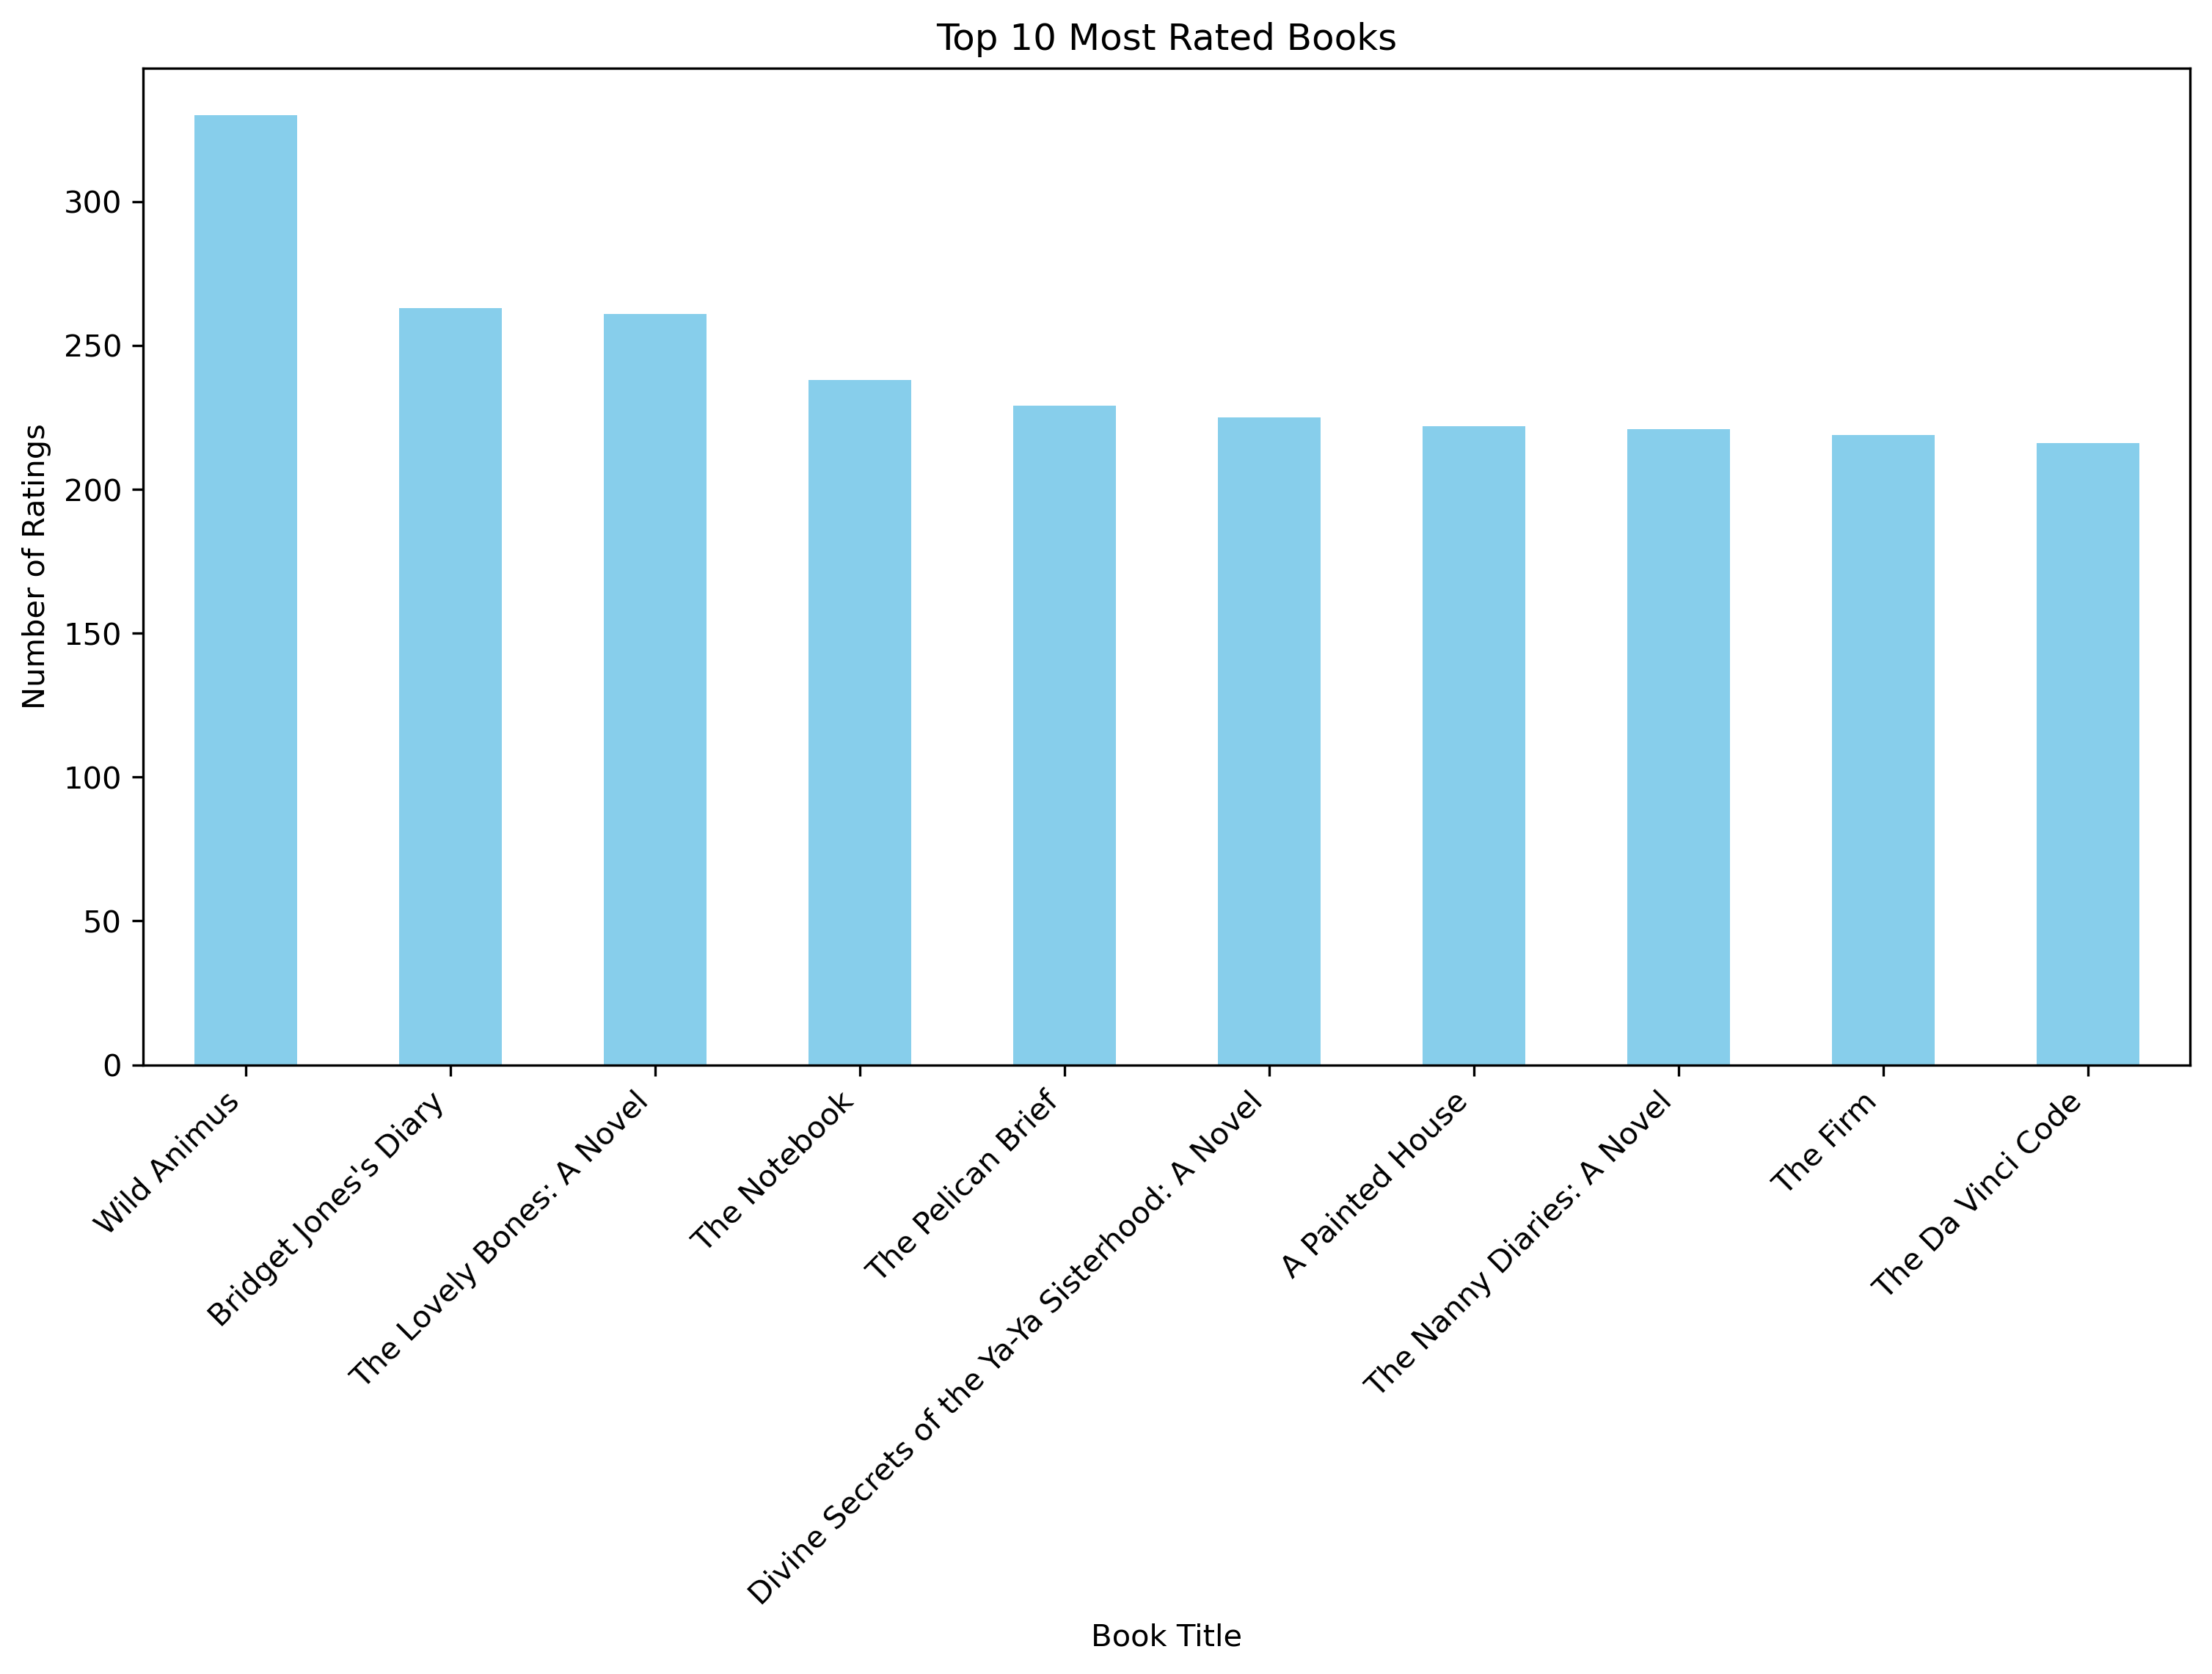

In [29]:
# 2. Bar Plot of Top 10 Most Rated Books
rating_count = final_ratings.groupby('Book-Title').size().nlargest(10)
plt.figure(figsize=(12, 6), dpi= 300)
rating_count.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Rated Books')
plt.xlabel('Book Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
plt.show()

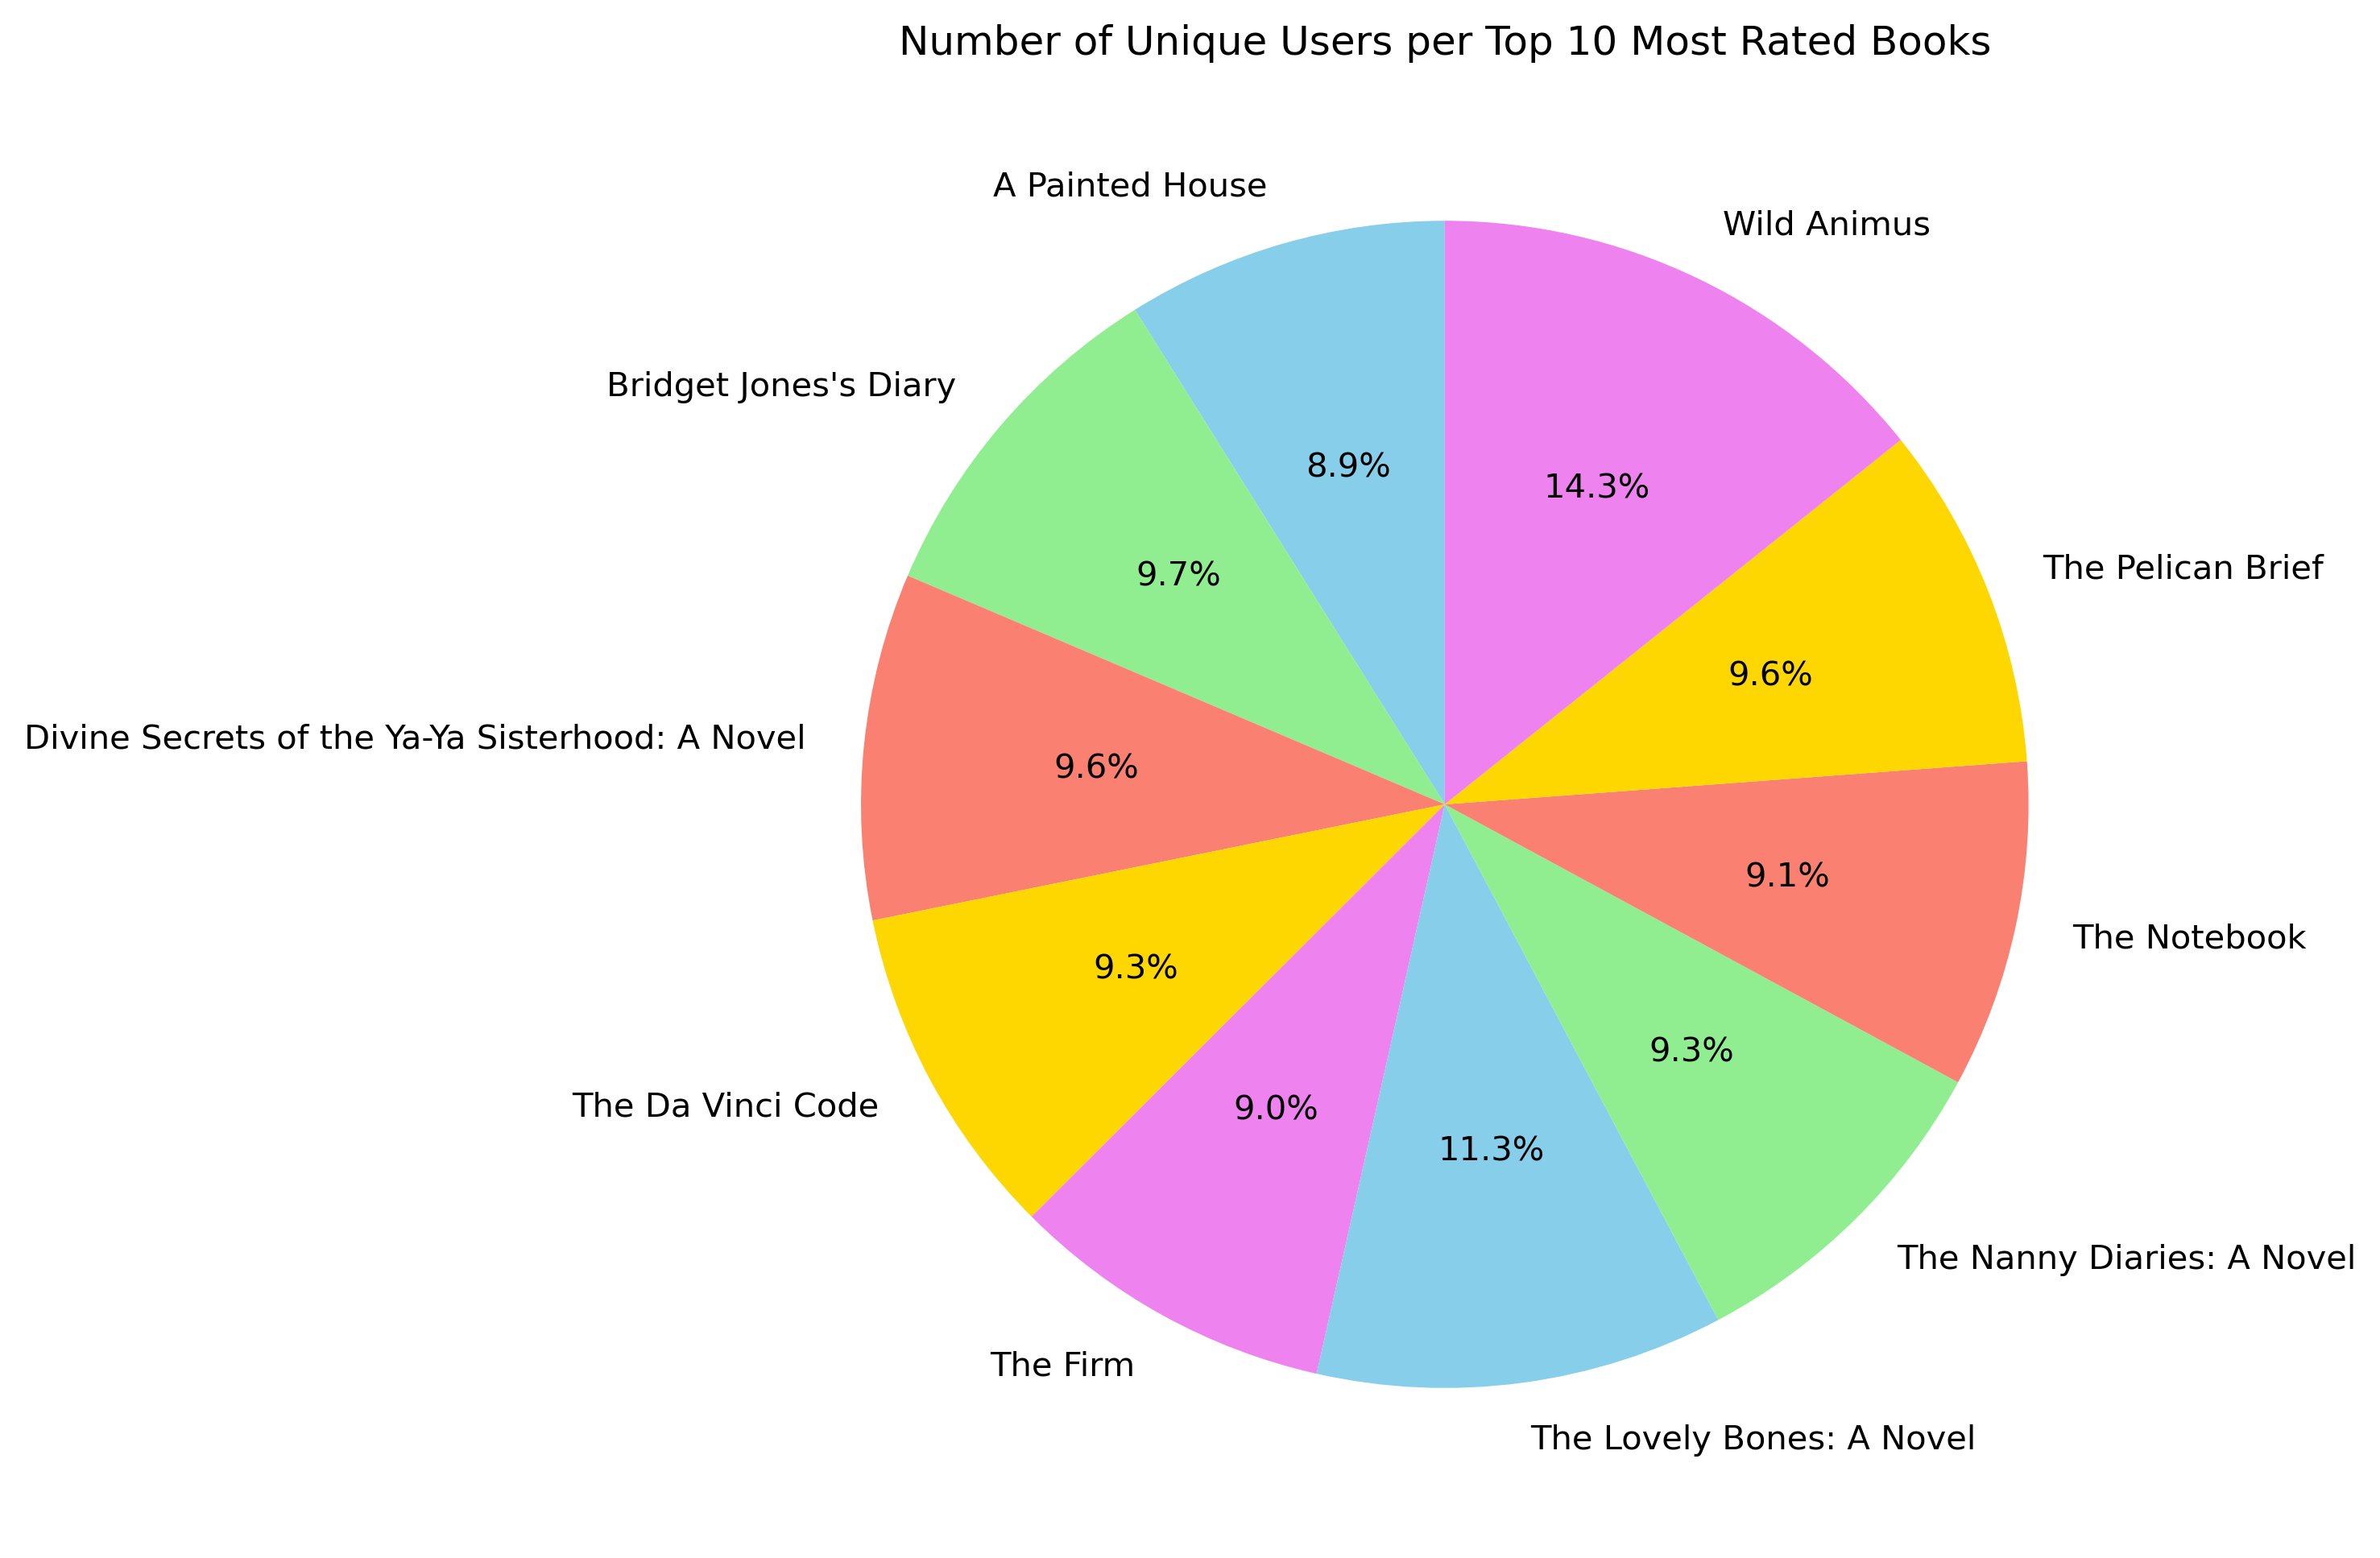

In [30]:
top_five_books = final_ratings['Book-Title'].value_counts().head(10).index

# Now, count the unique users who have rated each of these top five books
top_five_books_users = final_ratings[final_ratings['Book-Title'].isin(top_five_books)].groupby('Book-Title')['User-ID'].nunique()

# Plotting the pie chart for these five books
plt.figure(figsize=(8, 8),dpi=300)
top_five_books_users.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'salmon', 'gold', 'violet'])
plt.title('Number of Unique Users per Top 10 Most Rated Books')
plt.ylabel('')  # Pie charts do not need a y-label
plt.show()

In [31]:
# Train-test split for both content-based and collaborative filtering
train_data, test_data = train_test_split(final_ratings, test_size=0.3, random_state=42)


In [32]:
# Reset index of test_data
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.drop_duplicates(subset=['Book-Title', 'Book-Author', 'Publisher'])


In [33]:
# Content-based filtering
train_data['merged_words'] = train_data['merged_words'].fillna('')
test_data['merged_words'] = test_data['merged_words'].fillna('')
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X_train = vectorizer.fit_transform(train_data['merged_words'])
X_test = vectorizer.transform(test_data['merged_words'])
cosine_sim_test_train = cosine_similarity(X_test, X_train)

In [34]:
# Collaborative filtering
train_df = train_data.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating').fillna(0)
test_df = test_data.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating').fillna(0)
train_similarity = cosine_similarity(train_df)


In [35]:
def get_recommendations_for_specific_book(book_title, test_data, cosine_sim_matrix, train_data, k=5):
    book_indices = test_data[test_data['Book-Title'] == book_title].index.tolist()
    recommendations = {}
    for book_index in book_indices:
        similarities = cosine_sim_matrix[book_index].flatten()
        sorted_indices = np.argsort(-similarities)
        unique_titles = set()
        book_recommendations = []
        for i in sorted_indices:
            candidate_title = train_data.iloc[i]['Book-Title']
            if candidate_title != book_title and candidate_title not in unique_titles:
                book_recommendations.append(candidate_title)
                unique_titles.add(candidate_title)
                if len(book_recommendations) == k:
                    break
        if len(book_recommendations) == k:
            recommendations[book_title] = book_recommendations
            break
    return recommendations


In [36]:
book_title = "The Promise"
recommendations = get_recommendations_for_specific_book(book_title, test_data, cosine_sim_test_train, train_data)

# Check if recommendations are found for the book and print them in DataFrame format
if book_title in recommendations:
    recommendations_df = pd.DataFrame(recommendations[book_title], columns=['Recommended Books'])
    print(f"Recommendations for '{book_title}':")
    print(recommendations_df)
else:
    print(f"No recommendations found for: {book_title}")

    

Recommendations for 'The Promise':
           Recommended Books
0     The General's Daughter
1                Plum Island
2  The Bonesetter's Daughter
3                     Angels
4                The Wedding


In [37]:
def evaluate_recommendations(test_data, recommendations, train_data):
    actual_ratings = []
    predicted_ratings = []
    for idx, row in test_data.iterrows():
        actual_rating = row['Book-Rating']
        rec_books = recommendations.get(row['Book-Title'], [])
        ratings = [train_data[train_data['Book-Title'] == book]['Book-Rating'].mean() for book in rec_books if book in train_data['Book-Title'].values]

        # Handle cases where no ratings could be found for the recommended books
        if ratings:
            pred_rating = np.mean(ratings)
        else:
            pred_rating = 0  # Default rating if no ratings are found; adjust as necessary

        predicted_ratings.append(pred_rating)
        actual_ratings.append(actual_rating)
    
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

In [38]:
# Evaluate the recommendations
mse, mae, rmse = evaluate_recommendations(test_data, recommendations, train_data)

# Print out the evaluation results
print("-------------------------------------")
print(f"CBF - Mean Absolute Error: {mse}")
print("-------------------------------------")
print(f"CBF - Mean Absolute Error: {mae}")
print("-------------------------------------")
print(f"CBF - Mean Absolute Error: {rmse}")

-------------------------------------
CBF - Mean Absolute Error: 17.121052052961403
-------------------------------------
CBF - Mean Absolute Error: 2.089901376690574
-------------------------------------
CBF - Mean Absolute Error: 4.137759303410652


In [41]:
# Collaborative filtering: Recommendations and metrics calculation
def recommend_cf(book):
    if book in train_df.columns:
        book_index = np.where(train_df.columns == book)[0][0]
        distances = train_similarity[book_index]
        book_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]

        recommendations = [{'Recommended Book': train_df.columns[i[0]], 'Similarity Score': i[1]} for i in book_list]
        return pd.DataFrame(recommendations)
    else:
        return pd.DataFrame(columns=['Recommended Book', 'Similarity Score'])

In [60]:
# Example usage of recommend function
recommendations_cf = recommend_cf("Echoes")
print(recommendations_cf)

       Recommended Book  Similarity Score
0       Eyes of a Child          0.335855
1            The Search          0.304256
2              Airframe          0.251518
3      We'll Meet Again          0.225800
4  A Widow for One Year          0.225374


In [43]:
def predict_ratings_cf(similarity, ratings):
    pred_ratings = np.dot(similarity, ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    predicted_ratings = pd.DataFrame(pred_ratings, index=train_df.index, columns=train_df.columns)
    return predicted_ratings


In [44]:
predicted_ratings_cf = predict_ratings_cf(train_similarity, train_df.values)
predicted_ratings_test_cf = predicted_ratings_cf.reindex(index=test_df.index, columns=test_df.columns).fillna(0)

C:\Users\dp22acm\AppData\Local\Temp\ipykernel_11536\2281154563.py:2: RuntimeWarning: invalid value encountered in divide
  pred_ratings = np.dot(similarity, ratings) / np.array([np.abs(similarity).sum(axis=1)]).T


In [45]:
actual_ratings_test_cf = test_df.values.flatten()
predicted_ratings_test_cf = predicted_ratings_test_cf.values.flatten()


In [46]:
non_zero_indices_cf = np.flatnonzero(test_df.values)
actual_ratings_non_zero_cf = actual_ratings_test_cf[non_zero_indices_cf]
predicted_ratings_non_zero_cf = predicted_ratings_test_cf[non_zero_indices_cf]

In [47]:
mse_cf = mean_squared_error(actual_ratings_non_zero_cf, predicted_ratings_non_zero_cf)
mae_cf = mean_absolute_error(actual_ratings_non_zero_cf, predicted_ratings_non_zero_cf)
rmse_cf = np.sqrt(mse_cf)

In [48]:
print("-------------------------------------")
print("CF - Mean Squared Error:", mse_cf)
print("-------------------------------------")
print("CF - Mean Absolute Error:", mae_cf)
print("-------------------------------------")
print("CF - Root Mean Squared Error:", rmse_cf)
print("-------------------------------------")

-------------------------------------
CF - Mean Squared Error: 58.4820075763009
-------------------------------------
CF - Mean Absolute Error: 7.4046320346612085
-------------------------------------
CF - Root Mean Squared Error: 7.647352978403763
-------------------------------------


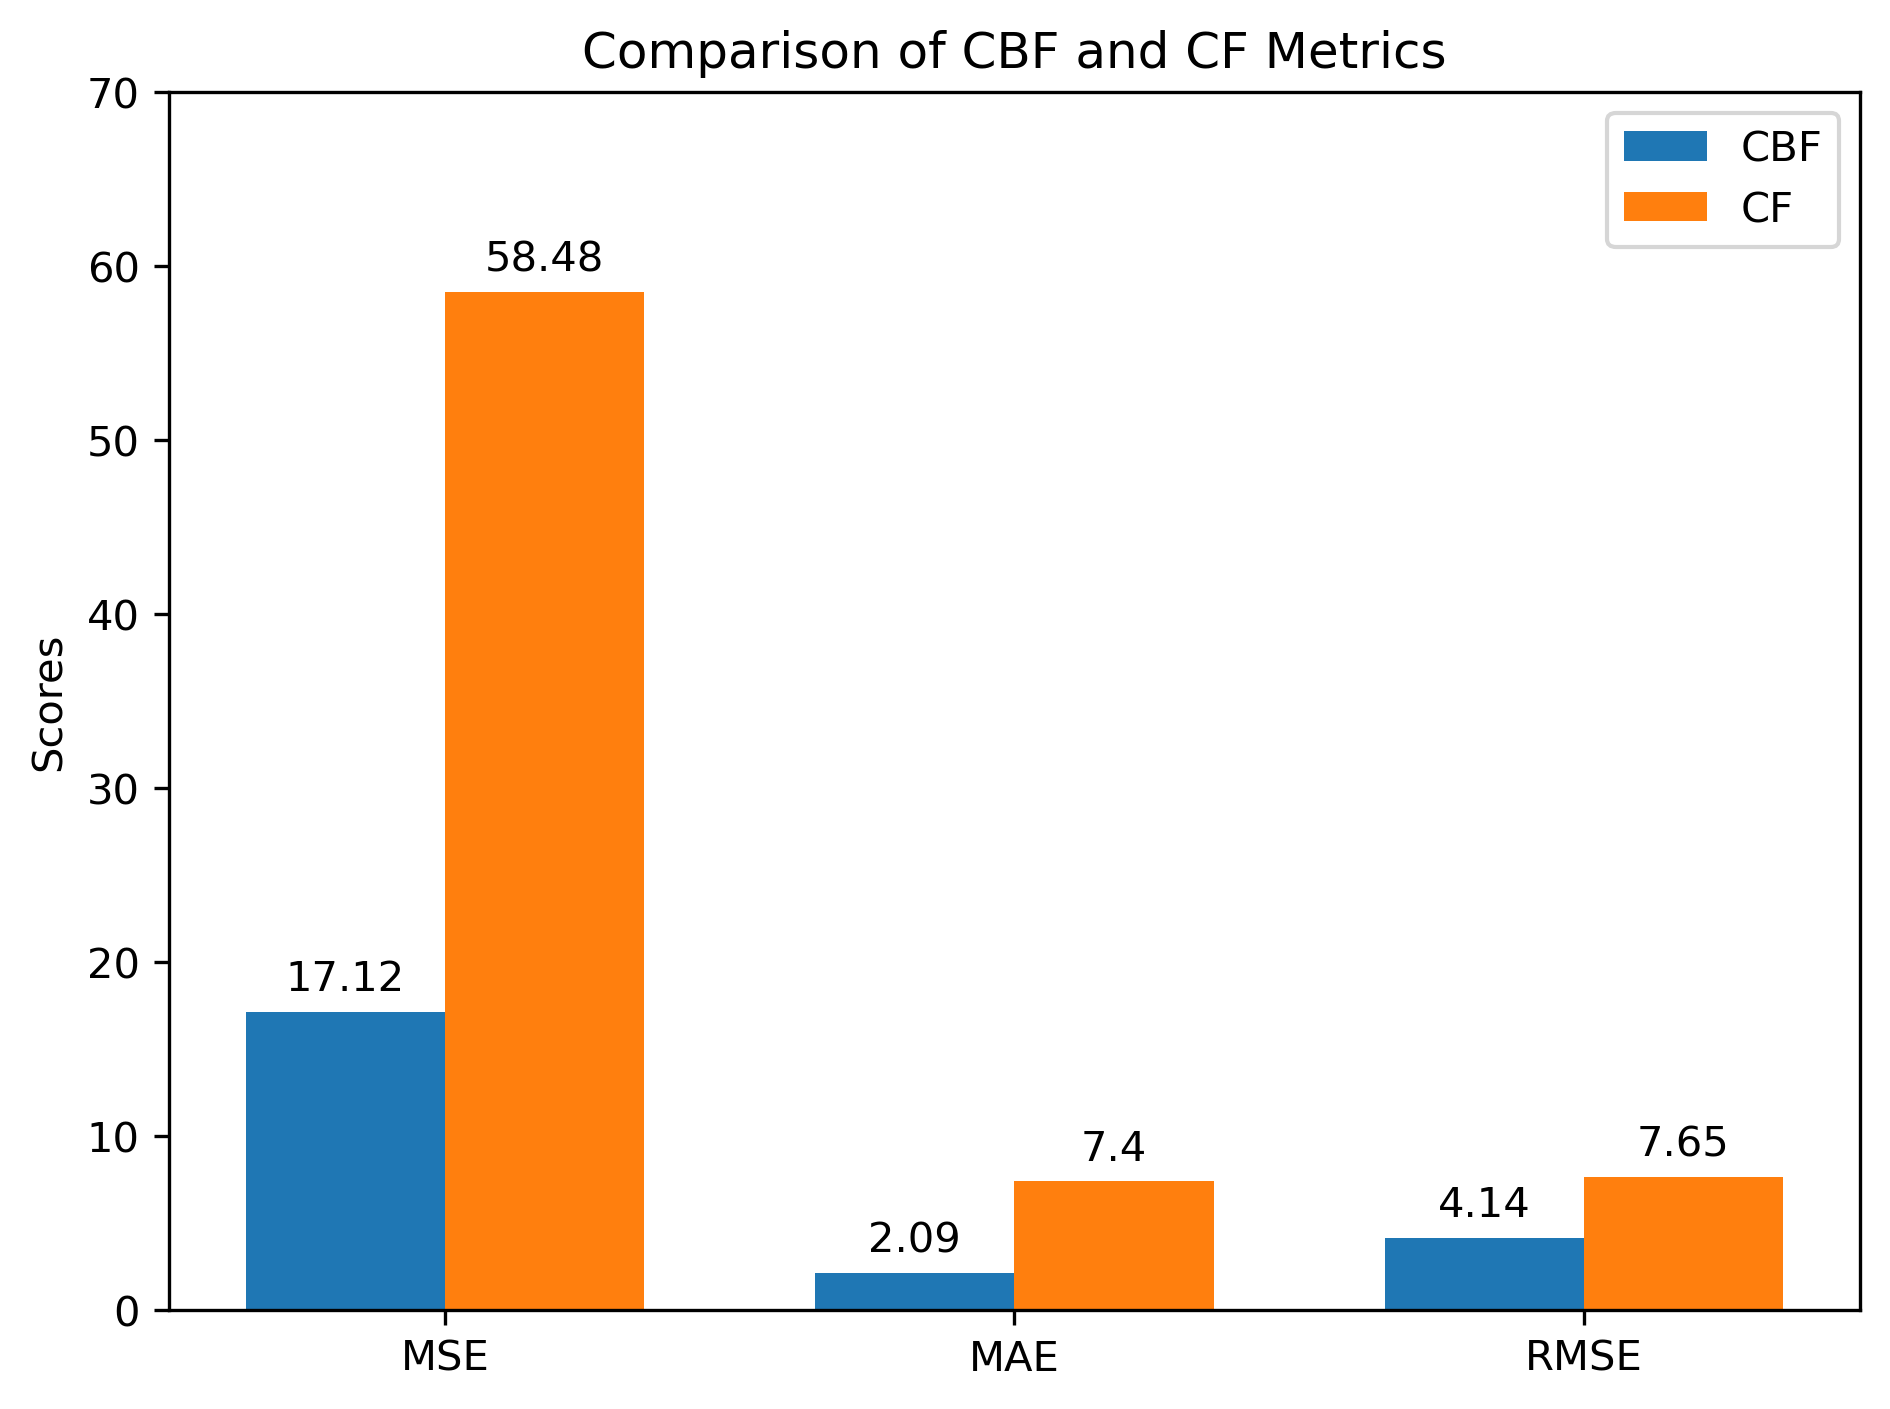

In [50]:

# Given metrics
cbf_metrics = {'MSE': mse, 'MAE': mae, 'RMSE': rmse}
cf_metrics = {'MSE': mse_cf, 'MAE': mae_cf, 'RMSE': rmse_cf}

# Labels for the bars
metric_names = ['MSE', 'MAE', 'RMSE']

# Values from the metrics dictionary
cbf_values = [cbf_metrics[metric] for metric in metric_names]
cf_values = [cf_metrics[metric] for metric in metric_names]

# Set the positions of the bars
x = np.arange(len(metric_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=300)
rects1 = ax.bar(x - width/2, cbf_values, width, label='CBF')
rects2 = ax.bar(x + width/2, cf_values, width, label='CF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of CBF and CF Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Set y-axis range from 0 to 70
ax.set_ylim(0, 70) 

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
